In [23]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from numpy import linalg as LA
import matplotlib.pyplot as plt
#os.environ["OMP_NUM_THREADS"] = '2'
#prevents the memory leak warning from kmeans (my sklearn package isn't up to date)

#Data taken from https://bmcecolevol.biomedcentral.com/articles/10.1186/s12862-022-01963-5
#Specifically, this is the "dpds" dataset

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [2]:
a = pd.read_table("unprocessed_bee_grm.tsv")

In [3]:
a = a.set_index("Sample ID",drop=True)
#Missing data to be imputed as the most common allele at that site... but first, recode
a

,Population,ms36,Unnamed: 3,ms116,Unnamed: 5,ms39,Unnamed: 7,ms80,Unnamed: 9,ms40,...,ms85,Unnamed: 17,ms41,Unnamed: 19,ms66,Unnamed: 21,ms86,Unnamed: 23,ms59,Unnamed: 25
Sample ID,,,,,,,,,,,,,,,,,,,,,
2013_Bt_0312,Poienita,217,217,349,355,222,222,277,280,183,...,267,267,228,237,147,150,286,286,346,350
2013_Bt_0313,Poienita,226,229,349,358,222,222,277,280,195,...,267,267,228,237,150,156,286,286,350,354
2013_Bt_0314,Poienita,232,235,349,355,228,231,274,280,195,...,267,267,228,228,150,153,286,289,354,354
2013_Bt_0315,Poienita,226,241,349,355,222,225,277,277,195,...,267,267,228,228,135,156,286,286,350,358
2013_Bt_0317,Poienita,232,238,355,355,222,222,277,277,195,...,267,267,228,228,144,156,286,289,342,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013_Bt_0185,Orsova,214,226,355,355,222,225,277,277,198,...,267,267,228,228,150,156,286,289,354,354
2013_Bt_0186,Orsova,229,232,349,364,222,225,274,277,198,...,267,267,228,228,156,162,280,286,350,350
2013_Bt_0187,Orsova,217,238,355,355,222,222,277,277,183,...,267,267,228,228,144,156,286,289,354,358


In [4]:
colnames2 = dict(zip(a.columns[2::2],[item +"_y" for item in  a.columns[1::2]]))

In [5]:
a = a.rename(columns=colnames2)

In [6]:
sites = list(a.columns[1::2])
sites2 = list(a.columns[2::2])

In [7]:
totaluniq = dict()
hapfreqs = dict()
for cola,colb in zip(sites,sites2):
    c1 = a.groupby(cola).size()
    c2 = a.groupby(colb).size()
    fullset = list(set(c1.index).union(set(c2.index)))
    for allele in fullset:
        if allele not in c1.index:
            c1[allele] = 0
        if allele not in c2.index:
            c2[allele] = 0
        
    ctotal = c1 + c2
    #What is the maximum
    mmax = ctotal.index[ctotal.argmax()]
    a[cola] = a[cola].replace(0,mmax)
    a[colb] = a[colb].replace(0,mmax)
    totaluniq[cola] =[k for k in list(ctotal.index) if k != 0]
    totaluniq[cola].sort()
    
    #Now do the haplotype freqs again
    c3 = a.groupby(cola).size()
    c4 = a.groupby(colb).size()
    fullset = list(set(c3.index).union(set(c4.index)))
    for allele in fullset:
        if allele not in c3.index:
            c3[allele] = 0
        if allele not in c4.index:
            c4[allele] = 0
        
    ctotal = c3 + c4
    hapfreqs[cola] = ctotal/ctotal.sum()

In [8]:
#now recode the sites
#Column indices will go from 1 to 98
fin = dict()
for cola,colb in zip(sites,sites2):
    #recode as haplotype... rows contain sample ids... columns contain site
    #cola provides the indices as they should apply to the sites...
    m_idx = sites.index(cola)
    for sample in a.index:
        #Determine the genotype at that site
        g1 = a[cola][sample]
        g2 = a[colb][sample]
#         g1_idx = (m_idx + 1)*(totaluniq[cola].index(g1) + 1) - 1
#         g2_idx = (m_idx + 1)*(totaluniq[cola].index(g2) + 1) - 1
        try:
            fin[cola + "_" + str(g1)][sample] += 1
        except:
            try:
                fin[cola + "_" + str(g1)][sample] = 1
            except:
                fin[cola + "_" + str(g1)] = dict()
                fin[cola + "_" + str(g1)][sample] = 1
        
        try:
            fin[cola + "_" + str(g2)][sample] += 1
        except:
            try:
                fin[cola + "_" + str(g2)][sample] = 1
            except:
                fin[cola + "_" + str(g2)] = dict()
                fin[cola + "_" + str(g2)][sample] = 1

In [9]:
recoded_grm_precursor = pd.DataFrame(fin)

In [10]:
recoded_grm_precursor = recoded_grm_precursor.fillna(0)

In [11]:
recoded_grm_precursor

,ms36_217,ms36_226,ms36_229,ms36_232,ms36_235,ms36_241,ms36_238,ms36_223,ms36_220,ms36_211,...,ms86_298,ms59_346,ms59_350,ms59_354,ms59_358,ms59_342,ms59_362,ms59_366,ms59_370,ms59_338
2013_Bt_0312,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bt_2014_106,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
Bt_2014_107,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bt_2014_110,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bt_2014_111,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bt_2014_128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Bt_2014_232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017_Bombus_355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2013_Bt_0142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
#To perform centering... we need the frequencies
len_col = recoded_grm_precursor.shape[0]
sigma = 0.0
tosubtract = dict()
for col in recoded_grm_precursor.columns:
    site,allele = col.split("_")
    allele = int(allele)
    mfreq = hapfreqs[site][allele]
    sigma += mfreq*(1 - mfreq)
    tosubtract[col] = dict(zip(recoded_grm_precursor.index,[mfreq*2]*len_col))

In [13]:
todivide = sigma*2.

In [14]:
tosubtractdf = pd.DataFrame(tosubtract)

In [15]:
Z = recoded_grm_precursor - tosubtractdf

In [22]:


def getbic(prediction,xu,thenum):
    #Calculates Bayes information criterion given the predicted group of each sample ,sample matrix, \
    #and number of groups
    wss = calculate_withingroupvariance(prediction,xu,thenum)
    t = wss/n_samples
    bic = (n_samples*np.log(t)) + (thenum*np.log(n_samples))
    return bic

def calculate_withingroupvariance(predictions,matrix,num_groups):
    #matrix components
    total = 0
    for pred in range(0,num_groups):
        predindex = [i for i in range(len(predictions)) if predictions[i] == pred]
        submatrix = matrix[predindex,:]
        mean = submatrix.mean(axis = 0)
        total += np.sum((submatrix - mean)**2)
    return total


def dopcamyway(mat,tol,norm,max_components=None):
    center = mat.sum(0)/mat.shape[0]
    zcentered = mat - center
    #Always center
    if norm:
        norm = np.apply_along_axis(lambda x : (np.sum(x * x) / mat.shape[0])**0.5,0,zcentered)
        norm = np.where(norm > 1e-8,norm,1)
    else:
        norm = 1.0
    z3 = zcentered/norm #this is what we multiply
    z4 = z3*(np.array([1/mat.shape[0]]*z3.shape[0])**0.5).reshape(-1,1)
    z5 = ( z4.T @ z4 )
    #It's all fine till here...
    
    
    if max_components == None:
        max_components = min(mat.shape)
    
    #I'm not checking for clones within the rows because removal of clones is already an implemented step
    #in population structure analysis
    w,v = LA.eig(z5)
    w = np.real(w)
    indices = w.argsort()[::-1]
    w = w[indices]
    v = np.real(v)
    v = v[:,indices]
    v = v[:,w/max(w) > tol]
    w = w[w/max(w) > tol]
    
    if len(w) < max_components > min(mat.shape):
        eigvals,eigvecs = w,v
    else:
        eigvals,eigvecs = w[:max_components],v[:,:max_components]
    
    xu = z3 @ eigvecs
    return xu

In [18]:
mat = Z.values
xu = dopcamyway(mat,1e-7,True)
#This is the R based dudi.pca implementation
#That this works was confirmed by using trace(as.dudi,edit = TRUE) for the adegenet R package
#It is rudimentary in that it doesn't set row weights or column weights and just normalizes using standard values


#The above function is equivalent to the following in python

center = mat.sum(0)/mat.shape[0]
zcentered = mat - center
norm = np.apply_along_axis(lambda x : (np.sum(x * x) / mat.shape[0])**0.5,0,zcentered)
norm = np.where(norm > 1e-8,norm,1)
z3 = zcentered/norm
z4 = z3*(np.array([1/mat.shape[0]]*z3.shape[0])**0.5).reshape(-1,1)
finpca = PCA(svd_solver="full")
xu2 = finpca.fit_transform(z3)
xu2 = xu2[:,finpca.explained_variance_ratio_ > 1e-5]
eigvecs = finpca.components_[:,finpca.explained_variance_ratio_ > 1e-5]
eigvals = finpca.singular_values_[finpca.explained_variance_ratio_ > 1e-5]



((xu2 - xu)**2).sum()
#certain columns carry mirrored signs... not sure why

64617.735618706276

In [19]:
reduction = 30 #we'd need to look at the PCA explained variance plot to make this decision!
n_samples = Z.shape[0]

finxu = xu[:,:reduction] #either xu or xu2
bics = []
allpreds = []

naivepreds = [0]*Z.shape[0]
bics.append(getbic(naivepreds,finxu,1))
allpreds.append(naivepreds)
#For other groups
n_groups = range(2,41)

import time


for thenum in n_groups:
    start_time = time.time()
    kmeaner = KMeans(n_clusters=thenum, init='k-means++', n_init=10, max_iter=1000, 
                     tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='full')
    prediction = kmeaner.fit_predict(finxu)
    print("--- %s seconds ---" % (time.time() - start_time))
#     #projector matrix = H*inverse((H_transpose*D*H))*H_transpose*D
#     #D is a weight matrix for each sample
#     D = np.identity(Z2.shape[1])/Z2.shape[1]
#     #H is a n x g matrix specifying which groups the samples belong to
#     #This is to be calculated using 
#     forH = np.random.randint(0,thenum,size=n_samples)
#     coords = np.array([[i,prediction[i]] for i in range(n_samples)])
#     H = np.zeros(shape=(n_samples,thenum))
#     H[tuple(coords.T)] = 1
    
#     #projector matrix
#     P = H @ np.linalg.inv(H.T @ D @ H) @ H.T @ D
    
#     pre1 = np.identity(n=P.shape[0]) - P
#     W = Z.values.T @ pre1.T @ D @ pre1 @ Z.values
#     #solution to DAPC is the eigenvectors of the matrix below. This is unused right now
#     geteigen = P @ xu @ np.linalg.inv(m_out2.T @ W @ m_out2) @ xu.T @ P.T @ D
    wss = calculate_withingroupvariance(prediction,finxu,thenum)
    
    t = wss/n_samples
#   wss2 = np.trace(m_out2.T @ W @ m_out2)
    bic = getbic(prediction,finxu,thenum)
    bics.append(bic)
    #Figure out which BIC is the best?
    allpreds.append(prediction)

n_groups = [1] + list(n_groups)

C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.16696715354919434 seconds ---
--- 0.13900113105773926 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.1420001983642578 seconds ---
--- 0.14100193977355957 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.1809980869293213 seconds ---
--- 0.1439964771270752 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.14899992942810059 seconds ---
--- 0.14400219917297363 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.14799880981445312 seconds ---
--- 0.1549994945526123 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.1529994010925293 seconds ---
--- 0.1510002613067627 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.1620016098022461 seconds ---
--- 0.16100096702575684 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.17200541496276855 seconds ---
--- 0.17300057411193848 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.17199468612670898 seconds ---
--- 0.18000197410583496 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.17900514602661133 seconds ---
--- 0.1820061206817627 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.18400025367736816 seconds ---
--- 0.1939983367919922 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.18799638748168945 seconds ---
--- 0.19299817085266113 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.19700288772583008 seconds ---
--- 0.18899965286254883 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.19600439071655273 seconds ---
--- 0.19699859619140625 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.20800185203552246 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.21200299263000488 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.21599984169006348 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.2180018424987793 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.2089996337890625 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.22500061988830566 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.20600128173828125 seconds ---
--- 0.20300006866455078 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.20600008964538574 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.20399975776672363 seconds ---


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


--- 0.21199870109558105 seconds ---


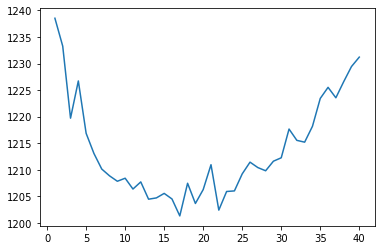

In [24]:
plt.plot(n_groups,bics)
#In terms of output, not much difference between xu and xu2... although I'm not sure that can be generalized

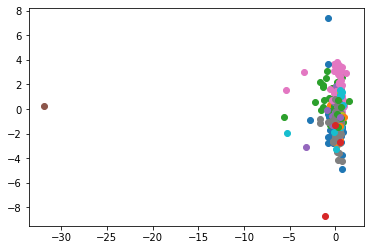

In [31]:
fig,ax = plt.subplots()
prediction = allpreds[14]
for mn in set(prediction):
    ax.scatter(finxu[[i for i in range(len(prediction)) if prediction[i] == mn],0],
               finxu[[i for i in range(len(prediction)) if prediction[i] == mn],1])
plt.show()

In [ ]:
#3 weird outliers...? what happened here?

In [203]:
%matplotlib notebook

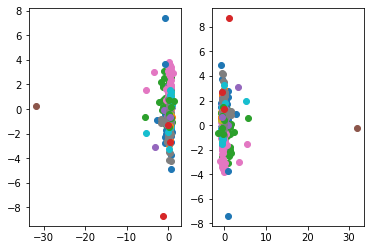

In [32]:
fig,axs = plt.subplots(1,2)
ax,ax2 = axs
prediction = allpreds[14]
for mn in set(prediction):
    ax.scatter(xu[[i for i in range(len(prediction)) if prediction[i] == mn],0],
               xu[[i for i in range(len(prediction)) if prediction[i] == mn],1])
    
    ax2.scatter(xu2[[i for i in range(len(prediction)) if prediction[i] == mn],0],
               xu2[[i for i in range(len(prediction)) if prediction[i] == mn],1])
plt.show()